In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

--2023-04-08 04:56:37--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M   181MB/s    in 1.6s    

2023-04-08 04:56:38 (181 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]



In [ ]:
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.2-bin-hadoop3'

In [ ]:
!pip install -q findspark

In [ ]:
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()#

In [ ]:
spark

In [ ]:
import gdown

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1v4OD0yJXQABjA9ZTfllpE9u4dPq0BOzf/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1v4OD0yJXQABjA9ZTfllpE9u4dPq0BOzf
To: /content/master.csv
100% 2.71M/2.71M [00:00<00:00, 108MB/s]


In [ ]:
suicide_df= spark.read.option("header","true").csv("master.csv")

In [ ]:
suicide_df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: string (nullable = true)
 |-- population: string (nullable = true)
 |-- suicides/100k pop: string (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: string (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita ($): string (nullable = true)
 |-- generation: string (nullable = true)



In [ ]:
suicide_df.select("suicides_no", "population", "gdp_per_capita ($)").describe().show()

+-------+------------------+------------------+------------------+
|summary|       suicides_no|        population|gdp_per_capita ($)|
+-------+------------------+------------------+------------------+
|  count|             27820|             27820|             27820|
|   mean|242.57440690150972|1844793.6173975556|16866.464414090584|
| stddev| 902.0479168336403|3911779.4417563565|18887.576472205576|
|    min|                 0|              1000|             10020|
|    max|               999|            999700|              9991|
+-------+------------------+------------------+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName("SuicideAnalysis").getOrCreate()

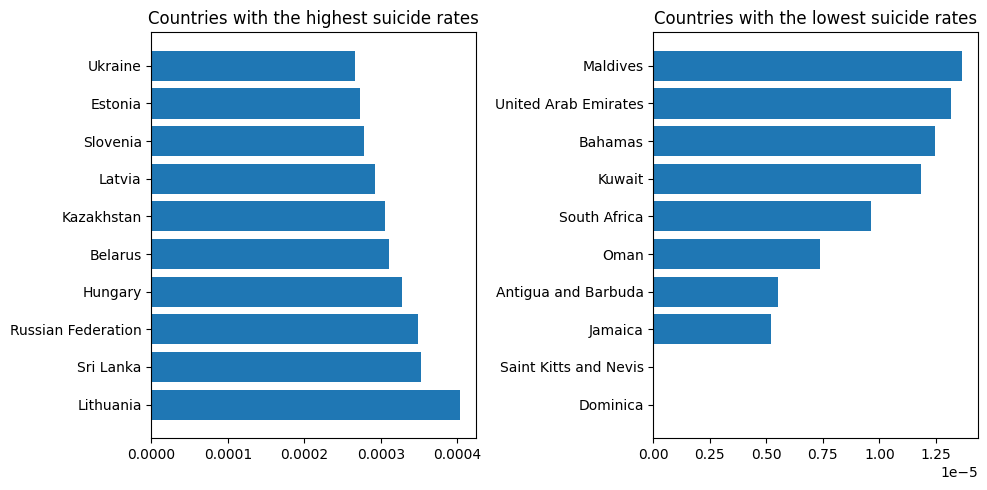

In [ ]:
avg_suicide_rate = suicide_df.groupBy("country", "year").agg(avg(col("suicides_no")/col("population")).alias("avg_suicide_rate"))
total_suicides = suicide_df.groupBy("country", "year").agg(sum(col("suicides_no")).alias("total_suicides"))
suicide_analysis = avg_suicide_rate.join(total_suicides, ["country", "year"])
highest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").desc()).limit(10)
lowest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").asc()).limit(10)
highest_suicide_rates_pd = highest_suicide_rates.toPandas()
lowest_suicide_rates_pd = lowest_suicide_rates.toPandas()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].barh(highest_suicide_rates_pd["country"], highest_suicide_rates_pd["avg_suicide_rate"])
ax[0].set_title("Countries with the highest suicide rates")
ax[1].barh(lowest_suicide_rates_pd["country"], lowest_suicide_rates_pd["avg_suicide_rate"])
ax[1].set_title("Countries with the lowest suicide rates")
plt.tight_layout()
plt.show()

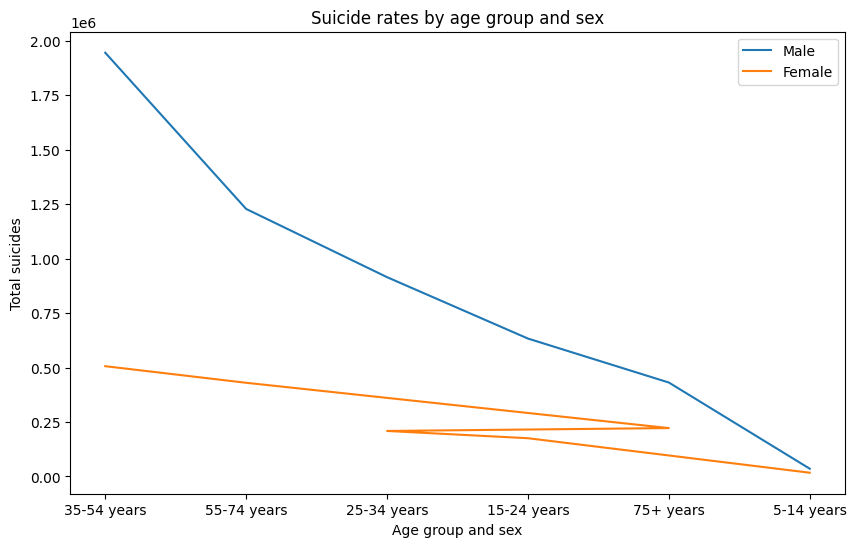

In [ ]:
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="male"]["age"], suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="male"]["total_suicides"], label="Male")
plt.plot(suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="female"]["age"], suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="female"]["total_suicides"], label="Female")
plt.title("Suicide rates by age group and sex")
plt.xlabel("Age group and sex")
plt.ylabel("Total suicides")
plt.legend()
plt.show()

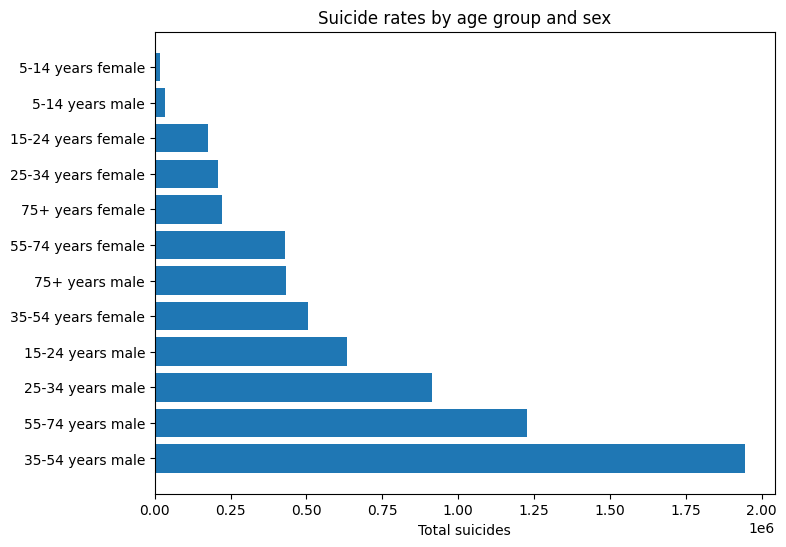

In [ ]:
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()
plt.figure(figsize=(8, 6))
plt.barh(suicide_by_age_sex_pd["age"] + " " + suicide_by_age_sex_pd["sex"], suicide_by_age_sex_pd["total_suicides"])
plt.title("Suicide rates by age group and sex")
plt.xlabel("Total suicides")
plt.show()

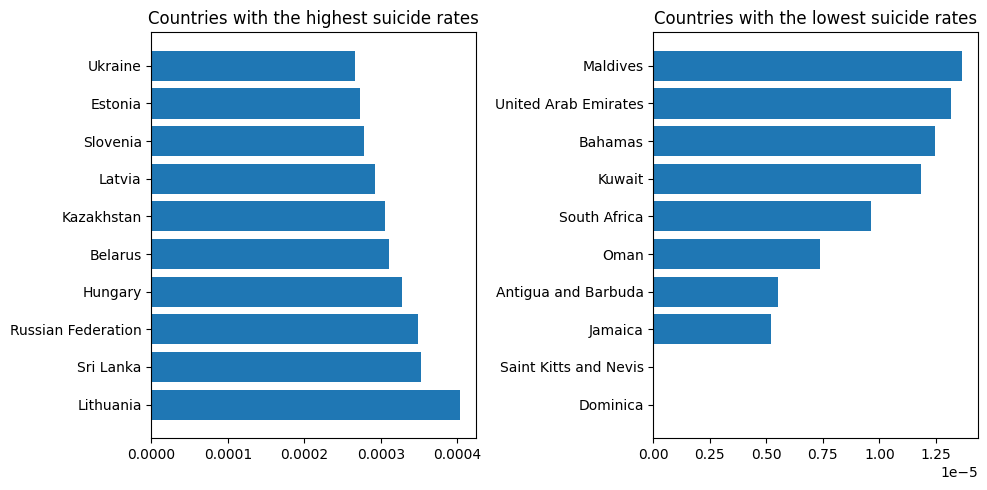

In [ ]:
highest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").desc()).limit(10)
lowest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").asc()).limit(10)
highest_suicide_rates_pd = highest_suicide_rates.toPandas()
lowest_suicide_rates_pd = lowest_suicide_rates.toPandas()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].barh(highest_suicide_rates_pd["country"], highest_suicide_rates_pd["avg_suicide_rate"])
ax[0].set_title("Countries with the highest suicide rates")
ax[1].barh(lowest_suicide_rates_pd["country"], lowest_suicide_rates_pd["avg_suicide_rate"])
ax[1].set_title("Countries with the lowest suicide rates")
plt.tight_layout()
plt.show()

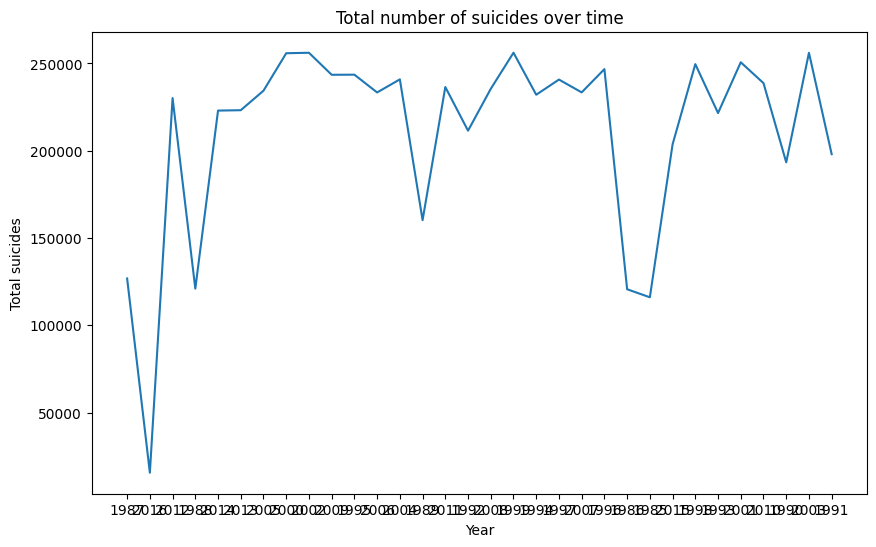

In [ ]:
suicides_over_time = suicide_df.groupBy("year").agg(sum(col("suicides_no")).alias("total_suicides"))
suicides_over_time_pd = suicides_over_time.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(suicides_over_time_pd["year"], suicides_over_time_pd["total_suicides"])
plt.title("Total number of suicides over time")
plt.xlabel("Year")
plt.ylabel("Total suicides")
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [ ]:
spark = SparkSession.builder.appName("Regression").getOrCreate()

In [ ]:
suicide_df.describe().show()

+-------+----------+------------------+------+-----------+------------------+------------------+------------------+--------------+-------------------+------------------+------------------+----------+------------------+------------------+
|summary|   country|              year|   sex|        age|       suicides_no|        population| suicides/100k pop|  country-year|       HDI for year| gdp_for_year ($) |gdp_per_capita ($)|generation|           age_Num|           gen_Num|
+-------+----------+------------------+------+-----------+------------------+------------------+------------------+--------------+-------------------+------------------+------------------+----------+------------------+------------------+
|  count|     27820|             27820| 27820|      27820|             27820|             27820|             27820|         27820|               8364|             27820|             27820|     27820|             27820|             27820|
|   mean|      null|2001.2583752695903|  null|  

In [ ]:
suicide_final=suicide_df.select(['country','year','sex','age','suicides_no','population','generation','gdp_per_capita ($)','suicides/100k pop'])

In [ ]:
suicide_final.describe().show()

+-------+----------+------------------+------+-----------+------------------+------------------+----------+------------------+------------------+
|summary|   country|              year|   sex|        age|       suicides_no|        population|generation|gdp_per_capita ($)| suicides/100k pop|
+-------+----------+------------------+------+-----------+------------------+------------------+----------+------------------+------------------+
|  count|     27820|             27820| 27820|      27820|             27820|             27820|     27820|             27820|             27820|
|   mean|      null|2001.2583752695903|  null|       null|242.57440690150972|1844793.6173975556|      null|16866.464414090584| 12.40999281092739|
| stddev|      null| 8.469055024441408|  null|       null| 902.0479168336403|3911779.4417563565|      null|18887.576472205576|18.904739639772153|
|    min|   Albania|              1985|female|15-24 years|                 0|               278|   Boomers|               25

In [ ]:
from pyspark.sql.types import IntegerType
suicide_final = suicide_final.withColumn("year", suicide_final["year"].cast(IntegerType()))
suicide_final= suicide_final.withColumn("suicides_no", suicide_final["suicides_no"].cast(IntegerType()))
suicide_final= suicide_final.withColumn("gdp_per_capita ($)", suicide_final["gdp_per_capita ($)"].cast(IntegerType()))
suicide_final= suicide_final.withColumn("suicides/100k pop", suicide_final["suicides/100k pop"].cast(IntegerType()))
suicide_final= suicide_final.withColumn("population", suicide_final["population"].cast(IntegerType()))

In [ ]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
gender_indexer = StringIndexer(inputCol='sex',outputCol='sexIndex')
gender_encoder = OneHotEncoder(inputCol='sexIndex',outputCol='sexVec')
age_indexer = StringIndexer(inputCol='age',outputCol='ageIndex')
age_encoder = OneHotEncoder(inputCol='ageIndex',outputCol='ageVec')
country_indexer = StringIndexer(inputCol='country',outputCol='countryIndex')
country_encoder = OneHotEncoder(inputCol='countryIndex',outputCol='countryVec')
generation_indexer = StringIndexer(inputCol='generation',outputCol='generationIndex')
generation_encoder = OneHotEncoder(inputCol='generationIndex',outputCol='generationVec')
assembler = VectorAssembler(inputCols=['countryVec','year','sexVec','ageVec','suicides_no','population','generationVec','gdp_per_capita ($)','suicides/100k pop'],outputCol='features')


In [ ]:
suicide_final.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- generation: string (nullable = true)
 |-- gdp_per_capita ($): integer (nullable = true)
 |-- suicides/100k pop: integer (nullable = true)



In [156]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol='features',labelCol='generationIndex')
pipe = Pipeline(stages=[gender_indexer,age_indexer,country_indexer,generation_indexer,gender_encoder,age_encoder,country_encoder,generation_encoder,assembler,log_reg])

In [157]:
train_data, test_data = suicide_final.randomSplit([0.7, .3])
  
# Fitting the model on training data
fit_model = pipe.fit(train_data)
  
# Storing the results on test data
results = fit_model.transform(test_data)
  
# Showing the results
results.show()

+-------+----+------+-----------+-----------+----------+---------------+------------------+-----------------+--------+--------+------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
|country|year|   sex|        age|suicides_no|population|     generation|gdp_per_capita ($)|suicides/100k pop|sexIndex|ageIndex|countryIndex|generationIndex|       sexVec|       ageVec|      countryVec|generationVec|            features|       rawPrediction|         probability|prediction|
+-------+----+------+-----------+-----------+----------+---------------+------------------+-----------------+--------+--------+------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
|Albania|1987|female|25-34 years|          4|    257200|        Boomers|               796|                1|     0.0|     4.0|   

In [158]:
# Importing the evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
  
# Calling the evaluator
res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='generationIndex')
  
# Evaluating the AUC on results
ROC_AUC = res.evaluate(results)

In [161]:
ROC_AUC

1.0